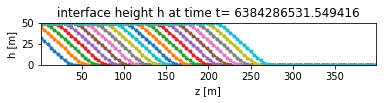

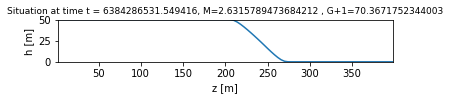

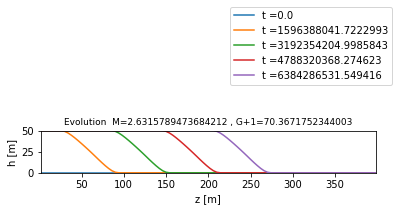

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
# Interface Model - for Rock Fluid Interaction II (AES 1320)
"""
## output parameters that you may need
# x   [1  x nx] vector with spatial co-ordinates of gridblock center
# h,  [1  x nx] vector with interface height at the endtime
# t_A [1  x nn] vector with intermediate times at which interface is stored
# h_A [nn x nx] matrix with the interface as function of space for the
#               times specified in t_A

"""

# Play around parameters
visco_o = 5e-3             # oil viscosity
visco_w = 1e-3             # water viscosity
uD = 1e-8                  # injection Darcy velocity
# to lesser extent

nx = 100                   # number of gridblocks
L = 400                    # domain size

#  domain properties
H = 50
theta = math.pi/4

# rock properties

phi = 0.38
kx = 1e-12

# Fluid properties

rho_o = 800               # oil desnity
rho_w = 1000              # water density
drho_wo = rho_w-rho_o     # density difference
g = 9.81                  # gravitational accelaration

# rock fluid properties

sor = 0.1
swc = 0.2
kroe = 0.95
krwe = 0.5

# end point mobilities
mob_we =  krwe*kx/visco_w
mob_oe =  kroe*kx/visco_o

# help variables
drho_wo_g_sin   = drho_wo * g * math.sin(theta)
drho_wo_g_cos   = drho_wo * g * math.cos(theta)

# numerical parameters
x = np.zeros(nx)
xv = np.zeros(nx+1)

dx = L/nx             # cell size

x = dx*(np.arange(1,nx+1) - 0.5)  # cell centroids
xv = np.arange(nx+1) * dx       # cell interface position
# Mobiltiy ratio and Gravity number

M = mob_we/mob_oe                           # mobility ratio
G = drho_wo_g_sin/(uD*visco_w/krwe/kx)      # Gravity number

"""
## CFL criteria (you may want to ignore this)
# Here the program determines the maximum time step the program may use
# such that the program remains numerically stable
# For explicit numerical scheme fluid is not allowed to travel 
# more than one gridblock in one time-step.
# For convection : dt < dx / v_max ( v_max is maximum velocity)
# For diffusion  : dt < 0.5 * dx^2 / D_max ( D_max maximum diffusivity)
"""
DS = phi*(1-sor-swc)

# # Determine maximum convective velocity
Qt = H*uD                    # specified injected flux
Qmax = Qt/DS*max( (1+G)/(M*H) , M-G/H )

#  Determine maximum diffusion coefficient
hTest = np.linspace(0,H,101)
FWt = M*hTest/(M*hTest+(H-hTest))
Dmax = max( Qt* FWt*(H-hTest)/H* G/M / math.tan(theta) ) / DS

#  Determine maximum allowable time step
dt = min(0.5*dx**2/Dmax, dx/Qmax)

#  Simulation time
max_time = 5e+10                                                                          # user specified max time  (not the endtime)
endtime  = min(max_time,0.6*L*(DS*H/Qt))                                                  # endtime of simulation
nn = 21                                                                                   # number of times that the interface will approximately be stored
dt = min(dt,endtime/(nn-1))                                                               # implications for time step
plotTime = np.arange(endtime/(nn-1), endtime + endtime/(nn-1) , endtime/(nn-1))           # time interval between to storage times
nt = math.ceil(endtime/dt)                                                                # number of time steps

# initial condition

h_init = np.zeros(nx)                                                                     # initial interface height distribution
h = h_init                                                                                # vector with interface heights used in simulation
"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%        1D simulation part 
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""
#  Constant coefficients in computation
CFL = dt/dx/DS


# Initialize of main variables
t = 0
pcount = 0
t_A = []
h_A = []
t_A.append(t)
h_A.append(h_A)

# Range vector
xri = np.arange(nx - 1)
xr = np.arange(nx)

# mobilities initialize
mob_o = np.zeros(nx)
mob_w = np.zeros(nx)
MW = np.zeros(nx)
MOW = np.zeros(nx)
FLUX_conv = np.zeros(nx)

# init arithmetic avg of mobilities for diffusive fluxes
MOW_A = np.zeros(nx+1)
FLUX_dif = np.zeros(nx - 1)
pos = np.zeros(nx - 1)
QW = np.zeros(nx+1)
h - np.zeros(nx)

fig = plt.figure(1)
ax = fig.add_subplot(111)


# Computational loop

while t < endtime:
    # increase timestep
    t += dt
    # set old height equal to present heaight
    h_old = h

    # oil and water mobility within each cell
    mob_o[xr] = mob_oe * (H - h[xr])
    mob_w[xr] = mob_we * h[xr]

    # mobility products (see fractional flow function)
    MW[xr] = mob_w[xr] / (mob_w[xr]+mob_o[xr])
    MOW[xr] = mob_o[xr] * MW[xr]

    # total convective flux (in cell center, consists of viscous + gravity term)
    FLUX_conv[xr] = Qt * MW[xr] - drho_wo_g_sin * MOW[xr]

    #     % diffusive flux (already computed at cell interface)
    #     % Arithmetic avg. mobilities required for diffusive fluxes
    MOW_A[xri+1] = (MOW[xri]+MOW[xri+1])/2
    MOW_A[0] = 2*MOW_A[2]-MOW_A[3]
    MOW_A[nx] = 2*MOW_A[nx-1]-MOW_A[nx-2]
    FLUX_dif[xri] = - drho_wo_g_cos * MOW_A[xri+1] * ( h[xri+1] - h[xri] ) / dx

    # upwind weighted flux (assuming water flow from cell (i) to cell (i+1) )
    # interface flux (convective: gravity + viscous)
    pos[xri] = (FLUX_conv[xri]>= FLUX_conv[xri+1])
    QW[xri+1] = pos[xri]*(FLUX_conv[xri]) + (1-pos[xri]) * FLUX_conv[xri+1] + FLUX_dif[xri]
    QW[0] = Qt

    # flux in last cell is extrapolated
    a = 1
    QW[nx] = (1+a)*QW[nx-1]-a*QW[nx-2]

    # saturation update
    h[xr] = h_old[xr] - CFL * (QW[xr + 1] - QW[xr])

    # Fudge-work to keep between proper bounds
    h = np.maximum(np.minimum(h, H), 0)

    # plotting of h(x,t) profile in space


    if t >= plotTime[pcount]:
        # plot various stuff
        pcount += 1
        t_A.append(t)
        h_A.append(h)
        # plot interface height (h(x,t) as function of position
        ax.plot(x,h,'.-')
        ax.set_xlabel('z [m]')
        ax.set_ylabel('h [m]')
        ax.set_title("interface height h at time t= {}".format(t))
        ax.set_ylim(-0.05*H, 1.05*H)
        ax.set_aspect('equal')
        ax.autoscale(enable=True, tight=True)
        ax.autoscale_view(-360 / 2 / math.pi * theta, 90)
        #plt.pause(0.01)
        #ax.clear()


"""
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
%
%        Figures
%
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
"""
"""
%% plot of the final interface height (at time t=endtime) as function of
%% the dip-co-ordinate
"""

fig = plt.figure(102)
ax = fig.add_subplot(111)
ax.plot(x,h)
ax.set_xlabel('z [m]')
ax.set_ylabel('h [m]')
ax.set_title("interface height h at time t= {}".format(t))
ax.set_ylim(-0.05 * H, 1.05 * H)
ax.set_aspect('equal')
ax.autoscale(enable=True, tight=True)
ax.set_title("Situation at time t = {}, M={} , G+1={}".format(t, M, G+1),  fontsize=9)

"""
%% plot of the interface height as function of the dip-co-ordinate at 
%% all times specified in the time vector t_A
"""
fig = plt.figure(103)
ax = fig.add_subplot(111)
h_Ar = np.zeros([len(h_A), nx])
t_Ar = np.zeros(len(h_A))
for i in range(1, np.shape(h_Ar)[0]):
    h_Ar[i,:] = h_A[i]
    t_Ar[i] = t_A[i]

rr = np.arange(0,pcount,5)
for i in range(0,pcount+1,5):
    ax.plot(x,h_Ar[i], label = "t ={}".format(t_Ar[i]))


ax.set_xlabel('z [m]')
ax.set_ylabel('h [m]')
ax.set_ylim(-0.05 * H, 1.05 * H)
ax.set_aspect('equal')
ax.legend(loc='upper left', bbox_to_anchor=(0.55, 4.05))
ax.set_title("Evolution  M={} , G+1={}".format(M, G+1),  fontsize=9)
ax.autoscale(enable=True, tight=True)

plt.show()
